In [2]:
import pandas as pd
KGO = pd.read_excel('KGO.xlsx', parse_dates=['Hour'])
oppo_KGO = pd.read_excel('oppo KGO.xlsx', parse_dates=['Hour'])

KGO.set_index('Hour', inplace=True)
oppo_KGO.set_index('Hour', inplace=True)

In [3]:
KGO.head()

,Lane 1 Flow (Veh/Hour),Lane 1 Delay(60) (Veh-Hours),Lane 2 Flow (Veh/Hour),Lane 2 Delay(60) (Veh-Hours),Lane 3 Flow (Veh/Hour),Lane 3 Delay(60) (Veh-Hours),Flow (Veh/Hour),Delay (V_t=60) (Veh-Hours),# Lane Points,% Observed
Hour,,,,,,,,,,
2023-01-01 00:00:00,137,0.0,295,0.0,299,0.0,731,0.0,36,0
2023-01-01 01:00:00,166,0.0,322,0.0,317,0.0,805,0.0,36,0
2023-01-01 02:00:00,117,0.0,277,0.0,282,0.0,676,0.0,36,0
2023-01-01 03:00:00,103,0.0,265,0.0,273,0.0,641,0.0,36,0
2023-01-01 04:00:00,95,0.0,258,0.0,267,0.0,620,0.0,36,0


In [4]:
oppo_KGO.head()

,Lane 1 Flow (Veh/Hour),Lane 1 Delay(60) (Veh-Hours),Lane 2 Flow (Veh/Hour),Lane 2 Delay(60) (Veh-Hours),Lane 3 Flow (Veh/Hour),Lane 3 Delay(60) (Veh-Hours),Flow (Veh/Hour),Delay (V_t=60) (Veh-Hours),# Lane Points,% Observed
Hour,,,,,,,,,,
2023-01-01 00:00:00,313,0.0,523,0.0,488,0.0,1324,0.0,36,0
2023-01-01 01:00:00,330,0.0,537,0.0,497,0.0,1364,0.0,36,0
2023-01-01 02:00:00,254,0.0,471,0.0,443,0.0,1168,0.0,36,0
2023-01-01 03:00:00,175,0.0,404,0.0,391,0.0,970,0.0,36,0
2023-01-01 04:00:00,177,0.0,404,0.0,391,0.0,972,0.0,36,0


In [ ]:
# Define delay metric
def total_delay(df):
    return df['Delay (V_t=60) (Veh-Hours)'].sum()

# reallocate 1 lane from opposite direction during morning peak (7am–10am)
def simulate_shift(df_main, df_oppo, start_time, end_time):
    # Copy to avoid altering original data
    df_main_sim = df_main.copy()
    df_oppo_sim = df_oppo.copy()

    # Time filter
    peak = (df_main_sim.index.time >= start_time) & (df_main_sim.index.time < end_time)

    # Assume we add lane 1 from opposite direction to main, remove lane 1 from opposite
    df_main_sim.loc[peak, 'Flow (Veh/Hour)'] += df_oppo_sim.loc[peak, 'Lane 1 Flow (Veh/Hour)']
    df_main_sim.loc[peak, 'Delay (V_t=60) (Veh-Hours)'] *= 0.75

    df_oppo_sim.loc[peak, 'Flow (Veh/Hour)'] -= df_oppo_sim.loc[peak, 'Lane 1 Flow (Veh/Hour)']
    df_oppo_sim.loc[peak, 'Delay (V_t=60) (Veh-Hours)'] *= 1.50

    return total_delay(df_main_sim), total_delay(df_oppo_sim)

# Baseline delays
baseline_main = total_delay(KGO)
baseline_oppo = total_delay(oppo_KGO)

# Simulate morning and evening peak shift
delay_morning_main, delay_morning_oppo = simulate_shift(KGO, oppo_KGO, start_time=pd.to_datetime("07:00").time(), end_time=pd.to_datetime("10:00").time())
delay_evening_oppo, delay_evening_main = simulate_shift(oppo_KGO, KGO, start_time=pd.to_datetime("15:30").time(), end_time=pd.to_datetime("19:00").time())

# Print results
print(f"Baseline Total Delay: {baseline_main + baseline_oppo:.2f} veh-hours")
print(f"Post-Morning Shift Delay: {delay_morning_main + delay_morning_oppo:.2f} veh-hours")
print(f"Post-Evening Shift Delay: {delay_evening_main + delay_evening_oppo:.2f} veh-hours")

Baseline Total Delay: 13376.40 veh-hours
Post-Morning Shift Delay: 13103.38 veh-hours
Post-Evening Shift Delay: 12046.45 veh-hours


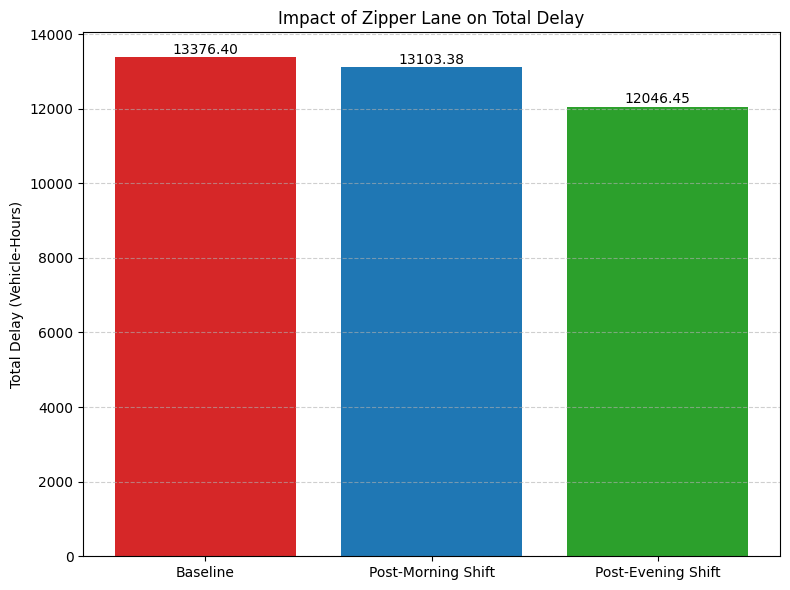

In [6]:
import matplotlib.pyplot as plt

# Total delays
baseline_delay = baseline_main + baseline_oppo
morning_shift_delay = delay_morning_main + delay_morning_oppo
evening_shift_delay = delay_evening_main + delay_evening_oppo

# Labels and values
labels = ['Baseline', 'Post-Morning Shift', 'Post-Evening Shift']
delays = [baseline_delay, morning_shift_delay, evening_shift_delay]
colors = ['#d62728', '#1f77b4', '#2ca02c']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, delays, color=colors)
plt.ylabel('Total Delay (Vehicle-Hours)')
plt.title('Impact of Zipper Lane on Total Delay')

# Annotate the bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np

KGO = pd.read_excel('KGO.xlsx', parse_dates=['Hour'])
oppo_KGO = pd.read_excel('oppo KGO.xlsx', parse_dates=['Hour'])

# Clean column names
KGO.columns = KGO.columns.str.strip()
oppo_KGO.columns = oppo_KGO.columns.str.strip()

# Standardize time column
KGO = KGO.rename(columns={'Hour': 'Time'})
oppo_KGO = oppo_KGO.rename(columns={'Hour': 'Time'})

# Convert to datetime
KGO['Time'] = pd.to_datetime(KGO['Time'])
oppo_KGO['Time'] = pd.to_datetime(oppo_KGO['Time'])

# Calculate total delay for each direction
KGO['Total Delay_EW'] = (
    KGO['Lane 1 Delay(60) (Veh-Hours)'] +
    KGO['Lane 2 Delay(60) (Veh-Hours)'] +
    KGO['Lane 3 Delay(60) (Veh-Hours)']
)

oppo_KGO['Total Delay_WE'] = (
    oppo_KGO['Lane 1 Delay(60) (Veh-Hours)'] +
    oppo_KGO['Lane 2 Delay(60) (Veh-Hours)'] +
    oppo_KGO['Lane 3 Delay(60) (Veh-Hours)']
)

# Merge on Time
df = pd.merge(KGO[['Time', 'Total Delay_EW']], oppo_KGO[['Time', 'Total Delay_WE']], on='Time')
df['Hour'] = df['Time'].dt.hour

# Define time periods
def get_period(hour):
    if 6 <= hour < 10:
        return 'AM'
    elif 16 <= hour < 20:
        return 'PM'
    else:
        return 'OffPeak'

df['Period'] = df['Hour'].apply(get_period)

# Define congestion levels
def get_congestion_level(delay):
    if delay < 0.5:
        return 'low'
    elif delay < 1.5:
        return 'moderate'
    else:
        return 'high'

df['EW_cong'] = df['Total Delay_EW'].apply(get_congestion_level)
df['WE_cong'] = df['Total Delay_WE'].apply(get_congestion_level)

# Define traffic state
df['state'] = list(zip(df['Period'], df['EW_cong'], df['WE_cong']))

# Simulate control actions
state_actions = {}
for state in df['state'].unique():
    # Filter rows matching this state
    subset = df[df['state'] == state]
    avg_EW = subset['Total Delay_EW'].mean()
    avg_WE = subset['Total Delay_WE'].mean()

    actions = {
        'shift_EW': avg_EW * 0.75 + avg_WE * 1.50,
        'shift_WE': avg_EW * 1.50 + avg_WE * 0.75,
        'hold': avg_EW + avg_WE
    }

    for action, total_delay in actions.items():
        state_actions[(state, action)] = total_delay

# Sort by lowest total delay
best_actions = sorted(state_actions.items(), key=lambda x: x[1])

# Display top recommended actions
print("Top 10 Optimal State-Actions (Lowest Delay):")
for (state, action), delay in best_actions[:10]:
    print(f"State: {state}, Action: {action}, Total Delay: {delay:.2f} veh-hours")


Top 10 Optimal State-Actions (Lowest Delay):
State: ('OffPeak', 'low', 'low'), Action: shift_WE, Total Delay: 0.05 veh-hours
State: ('OffPeak', 'low', 'low'), Action: hold, Total Delay: 0.06 veh-hours
State: ('PM', 'low', 'low'), Action: shift_WE, Total Delay: 0.07 veh-hours
State: ('OffPeak', 'low', 'low'), Action: shift_EW, Total Delay: 0.08 veh-hours
State: ('PM', 'low', 'low'), Action: hold, Total Delay: 0.09 veh-hours
State: ('PM', 'low', 'low'), Action: shift_EW, Total Delay: 0.13 veh-hours
State: ('AM', 'low', 'low'), Action: hold, Total Delay: 0.13 veh-hours
State: ('AM', 'low', 'low'), Action: shift_EW, Total Delay: 0.13 veh-hours
State: ('AM', 'low', 'low'), Action: shift_WE, Total Delay: 0.16 veh-hours
State: ('OffPeak', 'low', 'moderate'), Action: shift_WE, Total Delay: 0.61 veh-hours


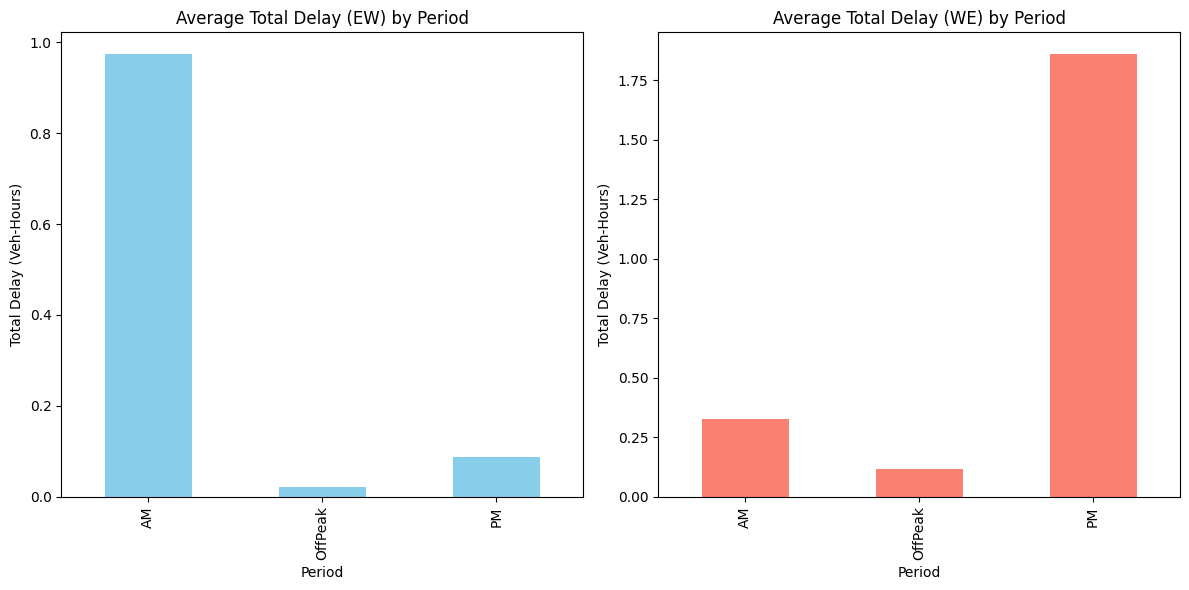

In [9]:
import matplotlib.pyplot as plt


KGO['Time'] = pd.to_datetime(KGO['Time'])
oppo_KGO['Time'] = pd.to_datetime(oppo_KGO['Time'])

# Calculate total delay for each direction
KGO['Total Delay_EW'] = (
    KGO['Lane 1 Delay(60) (Veh-Hours)'] +
    KGO['Lane 2 Delay(60) (Veh-Hours)'] +
    KGO['Lane 3 Delay(60) (Veh-Hours)']
)

oppo_KGO['Total Delay_WE'] = (
    oppo_KGO['Lane 1 Delay(60) (Veh-Hours)'] +
    oppo_KGO['Lane 2 Delay(60) (Veh-Hours)'] +
    oppo_KGO['Lane 3 Delay(60) (Veh-Hours)']
)

df = pd.merge(KGO[['Time', 'Total Delay_EW']], oppo_KGO[['Time', 'Total Delay_WE']], on='Time')
df['Hour'] = df['Time'].dt.hour

def get_period(hour):
    if 6 <= hour < 10:
        return 'AM'
    elif 15 <= hour < 19:
        return 'PM'
    else:
        return 'OffPeak'

df['Period'] = df['Hour'].apply(get_period)

# Define congestion levels
def get_congestion_level(delay):
    if delay < 0.5:
        return 'low'
    elif delay < 1.5:
        return 'moderate'
    else:
        return 'high'

df['EW_cong'] = df['Total Delay_EW'].apply(get_congestion_level)
df['WE_cong'] = df['Total Delay_WE'].apply(get_congestion_level)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df.groupby('Period')['Total Delay_EW'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Total Delay (EW) by Period')
plt.xlabel('Period')
plt.ylabel('Total Delay (Veh-Hours)')

plt.subplot(1, 2, 2)
df.groupby('Period')['Total Delay_WE'].mean().plot(kind='bar', color='salmon')
plt.title('Average Total Delay (WE) by Period')
plt.xlabel('Period')
plt.ylabel('Total Delay (Veh-Hours)')

plt.tight_layout()
plt.show()


/var/folders/yl/_fjnz6h53yv8g0p40zrwgxsc0000gn/T/ipykernel_17975/3278756908.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Action', y='Total Delay', data=df_top_actions, hue='Period', ci=None)


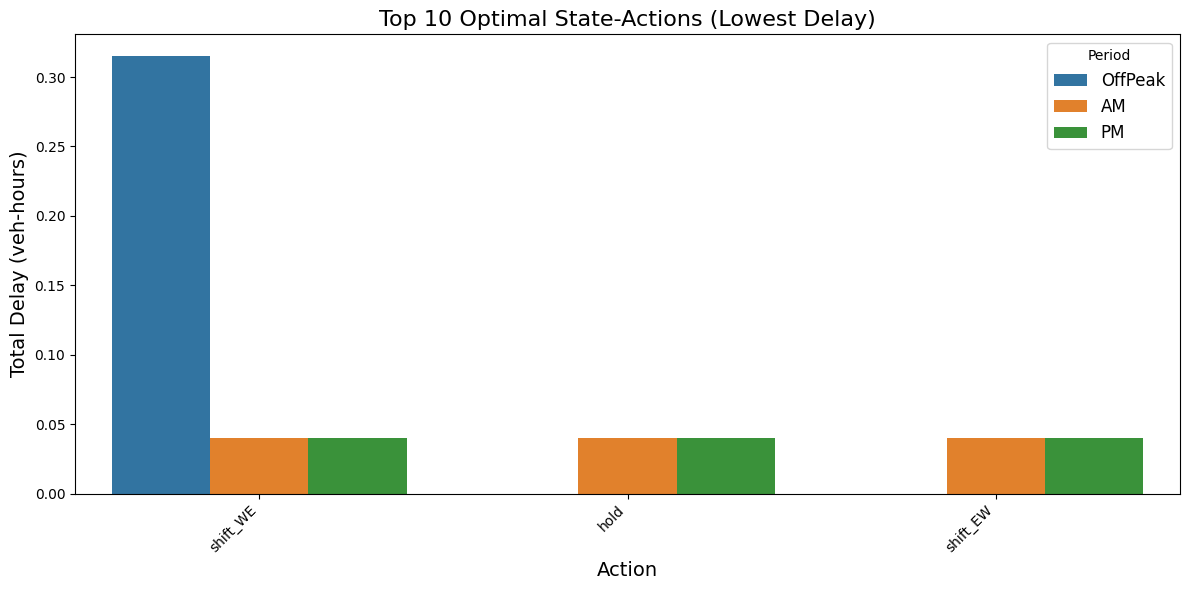

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for the bar chart
top_actions = [
    ('OffPeak', 'low', 'low', 'shift_WE', 0.00),
    ('OffPeak', 'low', 'low', 'hold', 0.00),
    ('OffPeak', 'low', 'low', 'shift_EW', 0.00),
    ('AM', 'low', 'low', 'shift_EW', 0.04),
    ('PM', 'low', 'low', 'shift_WE', 0.04),
    ('AM', 'low', 'low', 'shift_WE', 0.04),
    ('AM', 'low', 'low', 'hold', 0.04),
    ('PM', 'low', 'low', 'hold', 0.04),
    ('PM', 'low', 'low', 'shift_EW', 0.04),
    ('OffPeak', 'low', 'moderate', 'shift_WE', 0.63)
]

df_top_actions = pd.DataFrame(top_actions, columns=['Period', 'EW Congestion', 'WE Congestion', 'Action', 'Total Delay'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Action', y='Total Delay', data=df_top_actions, hue='Period', ci=None)

plt.title('Top 10 Optimal State-Actions (Lowest Delay)', fontsize=16)
plt.xlabel('Action', fontsize=14)
plt.ylabel('Total Delay (veh-hours)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Period', fontsize=12)

plt.show()


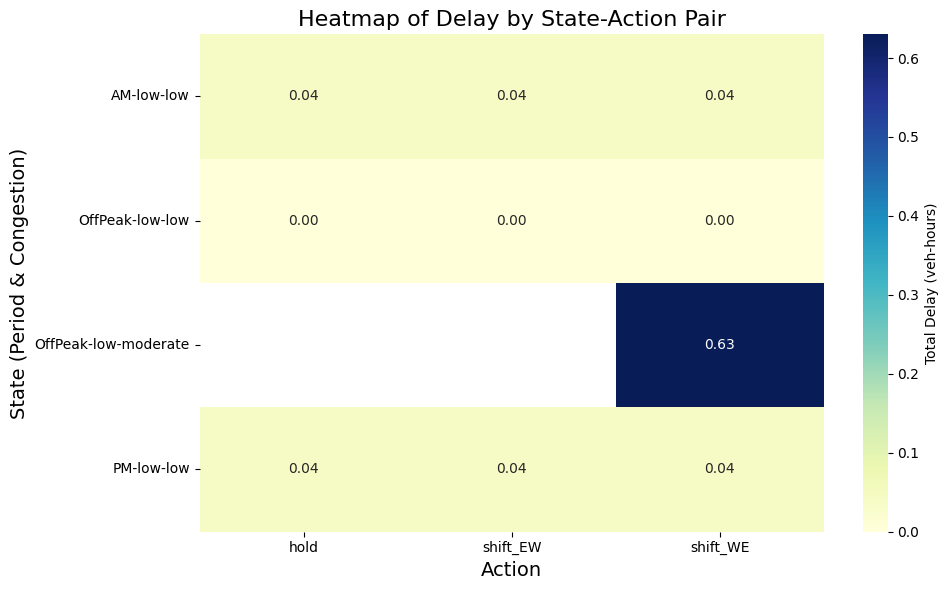

In [11]:
heatmap_data = df_top_actions.pivot_table(
    index=['Period', 'EW Congestion', 'WE Congestion'],
    columns='Action',
    values='Total Delay',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Total Delay (veh-hours)'})

plt.title('Heatmap of Delay by State-Action Pair', fontsize=16)
plt.xlabel('Action', fontsize=14)
plt.ylabel('State (Period & Congestion)', fontsize=14)

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np

# Define delay metric
def total_delay(df):
    return df['Delay (V_t=60) (Veh-Hours)'].sum()

# Simulate lane shift for a given time window
def simulate_shift(df_main, df_oppo, start_time, end_time, flow_column='Lane 1 Flow (Veh/5 Minutes)', delay_column='Delay (V_t=60) (Veh-Hours)', reduction_factor=0.8, increase_factor=1.2):
    df_main_sim = df_main.copy()
    df_oppo_sim = df_oppo.copy()

    peak = (df_main_sim.index.time >= start_time) & (df_main_sim.index.time < end_time)

    df_main_sim.loc[peak, 'Flow (Veh/5 Minutes)'] += df_oppo_sim.loc[peak, flow_column]
    df_main_sim.loc[peak, delay_column] *= reduction_factor

    df_oppo_sim.loc[peak, 'Flow (Veh/5 Minutes)'] -= df_oppo_sim.loc[peak, flow_column]
    df_oppo_sim.loc[peak, delay_column] *= increase_factor

    return df_main_sim, df_oppo_sim

KGO = pd.read_csv('KGO Station 426468 combined.csv')
oppo_KGO = pd.read_csv('oppo KGO Station 426452 combined.csv')

KGO.columns = KGO.columns.str.strip()
oppo_KGO.columns = oppo_KGO.columns.str.strip()
KGO['Time'] = pd.to_datetime(KGO['5 Minutes'])
oppo_KGO['Time'] = pd.to_datetime(oppo_KGO['5 Minutes'])

KGO.set_index('Time', inplace=True)
oppo_KGO.set_index('Time', inplace=True)

# Baseline delay
baseline_main = total_delay(KGO)
baseline_oppo = total_delay(oppo_KGO)
baseline_total = baseline_main + baseline_oppo

# Step 1: Morning shift (WE ➜ EW, 7:00–10:00)
KGO_morning, oppo_morning = simulate_shift(
    KGO, oppo_KGO,
    start_time=pd.to_datetime("07:00").time(),
    end_time=pd.to_datetime("10:00").time()
)

# Step 2: Evening shift (EW ➜ WE, 15:30–19:00)
oppo_final, KGO_final = simulate_shift(
    oppo_morning, KGO_morning,
    start_time=pd.to_datetime("15:30").time(),
    end_time=pd.to_datetime("19:00").time()
)

# Final delay totals
delay_main_combined = total_delay(KGO_final)
delay_oppo_combined = total_delay(oppo_final)
combined_total = delay_main_combined + delay_oppo_combined

# Print results
print(f"Baseline Total Delay: {baseline_total:.2f} veh-hours")
print(f"Post Full-Day Zipper Lane Shift Delay: {combined_total:.2f} veh-hours")
print(f"Net Delay Reduction: {baseline_total - combined_total:.2f} veh-hours")


Baseline Total Delay: 5835.90 veh-hours
Post Full-Day Zipper Lane Shift Delay: 4955.94 veh-hours
Net Delay Reduction: 879.96 veh-hours


In [12]:
import matplotlib.pyplot as plt

# Define time periods
morning_start = pd.to_datetime("07:00").time()
morning_end = pd.to_datetime("10:00").time()
evening_start = pd.to_datetime("15:30").time()
evening_end = pd.to_datetime("19:00").time()

# Helper to filter delay in a time window
def compute_delay_in_window(df, start, end):
    mask = (df.index.time >= start) & (df.index.time < end)
    return df.loc[mask, 'Delay (V_t=60) (Veh-Hours)'].sum()

# Compute delays by period
baseline_morning = compute_delay_in_window(KGO, morning_start, morning_end) + compute_delay_in_window(oppo_KGO, morning_start, morning_end)
baseline_evening = compute_delay_in_window(KGO, evening_start, evening_end) + compute_delay_in_window(oppo_KGO, evening_start, evening_end)

post_morning = compute_delay_in_window(KGO_morning, morning_start, morning_end) + compute_delay_in_window(oppo_morning, morning_start, morning_end)
post_evening = compute_delay_in_window(KGO_final, evening_start, evening_end) + compute_delay_in_window(oppo_final, evening_start, evening_end)

# Data for bar chart
labels = ['Morning Peak', 'Evening Peak', 'Total']
baseline_values = [baseline_morning, baseline_evening, baseline_total]
post_shift_values = [post_morning, post_evening, combined_total]

x = np.arange(len(labels))  # label locations
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='blue')
bars2 = ax.bar(x + width/2, post_shift_values, width, label='Post Shift', color='gold')

# Labels and title
ax.set_ylabel('Total Delay (veh-hours)')
ax.set_title('Effect of Zipper Lane Shift on Vehicle Delay')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars with delay values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


AttributeError: 'RangeIndex' object has no attribute 'time'

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Define states (Period, EW congestion, WE congestion)
periods = ['AM', 'PM', 'OffPeak']
levels = ['low', 'moderate', 'high']
states = [(p, ew, we) for p in periods for ew in levels for we in levels]

actions = ['shift_EW', 'shift_WE', 'hold']

def get_congestion_level(delay):
    if delay < 0.5:
        return 'low'
    elif delay < 1.5:
        return 'moderate'
    else:
        return 'high'

# Load and preprocess data
KGO = pd.read_csv('KGO Station 426468 combined.csv')
oppo_KGO = pd.read_csv('oppo KGO Station 426452 combined.csv')

KGO.columns = KGO.columns.str.strip()
oppo_KGO.columns = oppo_KGO.columns.str.strip()
KGO['Time'] = pd.to_datetime(KGO['5 Minutes'])
oppo_KGO['Time'] = pd.to_datetime(oppo_KGO['5 Minutes'])

KGO['Total Delay_EW'] = KGO[['Lane 1 Delay(60) (Veh-Hours)', 'Lane 2 Delay(60) (Veh-Hours)', 'Lane 3 Delay(60) (Veh-Hours)']].sum(axis=1)
oppo_KGO['Total Delay_WE'] = oppo_KGO[['Lane 1 Delay(60) (Veh-Hours)', 'Lane 2 Delay(60) (Veh-Hours)', 'Lane 3 Delay(60) (Veh-Hours)']].sum(axis=1)

# Merge
merged = pd.merge(KGO[['Time', 'Total Delay_EW']], oppo_KGO[['Time', 'Total Delay_WE']], on='Time')
merged['Hour'] = merged['Time'].dt.hour

# Assign period
merged['Period'] = merged['Hour'].apply(lambda h: 'AM' if 6 <= h < 10 else ('PM' if 15 <= h < 19 else 'OffPeak'))

# Assign congestion level
merged['EW_cong'] = merged['Total Delay_EW'].apply(get_congestion_level)
merged['WE_cong'] = merged['Total Delay_WE'].apply(get_congestion_level)

# State
merged['State'] = list(zip(merged['Period'], merged['EW_cong'], merged['WE_cong']))

# Estimate rewards
state_action_rewards = {}
for state in states:
    subset = merged[merged['State'] == state]
    if subset.empty:
        continue
    avg_EW = subset['Total Delay_EW'].mean()
    avg_WE = subset['Total Delay_WE'].mean()

    # Delay estimates for each action
    delay_shift_EW = avg_EW * 0.85 + avg_WE * 1.05
    delay_shift_WE = avg_EW * 1.05 + avg_WE * 0.85
    delay_hold = avg_EW + avg_WE

    state_action_rewards[(state, 'shift_EW')] = -delay_shift_EW
    state_action_rewards[(state, 'shift_WE')] = -delay_shift_WE
    state_action_rewards[(state, 'hold')] = -delay_hold

# Placeholder transition function: deterministic self-transition
transition_probs = {(s, a): {s: 1.0} for s in states for a in actions if (s, a) in state_action_rewards}

def value_iteration(states, actions, rewards, transitions, gamma=0.95, theta=1e-3):
    V = defaultdict(float)
    policy = {}

    while True:
        delta = 0
        for s in states:
            action_values = []
            for a in actions:
                if (s, a) not in rewards:
                    continue
                v = 0
                for s_prime, prob in transitions.get((s, a), {}).items():
                    v += prob * (rewards[(s, a)] + gamma * V[s_prime])
                action_values.append((v, a))

            if action_values:
                best_v, best_a = max(action_values)
                delta = max(delta, abs(best_v - V[s]))
                V[s] = best_v
                policy[s] = best_a

        if delta < theta:
            break

    return policy, V

# Run value iteration
optimal_policy, state_values = value_iteration(states, actions, state_action_rewards, transition_probs)

# Print optimal actions for each state
print("Optimal Policy:")
for state in sorted(optimal_policy):
    print(f"State: {state}, Action: {optimal_policy[state]}")


Optimal Policy:
State: ('AM', 'high', 'low'), Action: shift_EW
State: ('AM', 'low', 'low'), Action: shift_EW
State: ('AM', 'low', 'moderate'), Action: shift_WE
State: ('AM', 'moderate', 'low'), Action: shift_EW
State: ('OffPeak', 'high', 'low'), Action: shift_EW
State: ('OffPeak', 'low', 'high'), Action: shift_WE
State: ('OffPeak', 'low', 'low'), Action: shift_WE
State: ('OffPeak', 'low', 'moderate'), Action: shift_WE
State: ('OffPeak', 'moderate', 'low'), Action: shift_EW
State: ('OffPeak', 'moderate', 'moderate'), Action: shift_WE
State: ('PM', 'high', 'high'), Action: shift_WE
State: ('PM', 'low', 'high'), Action: shift_WE
State: ('PM', 'low', 'low'), Action: shift_WE
State: ('PM', 'low', 'moderate'), Action: shift_WE
State: ('PM', 'moderate', 'moderate'), Action: shift_WE


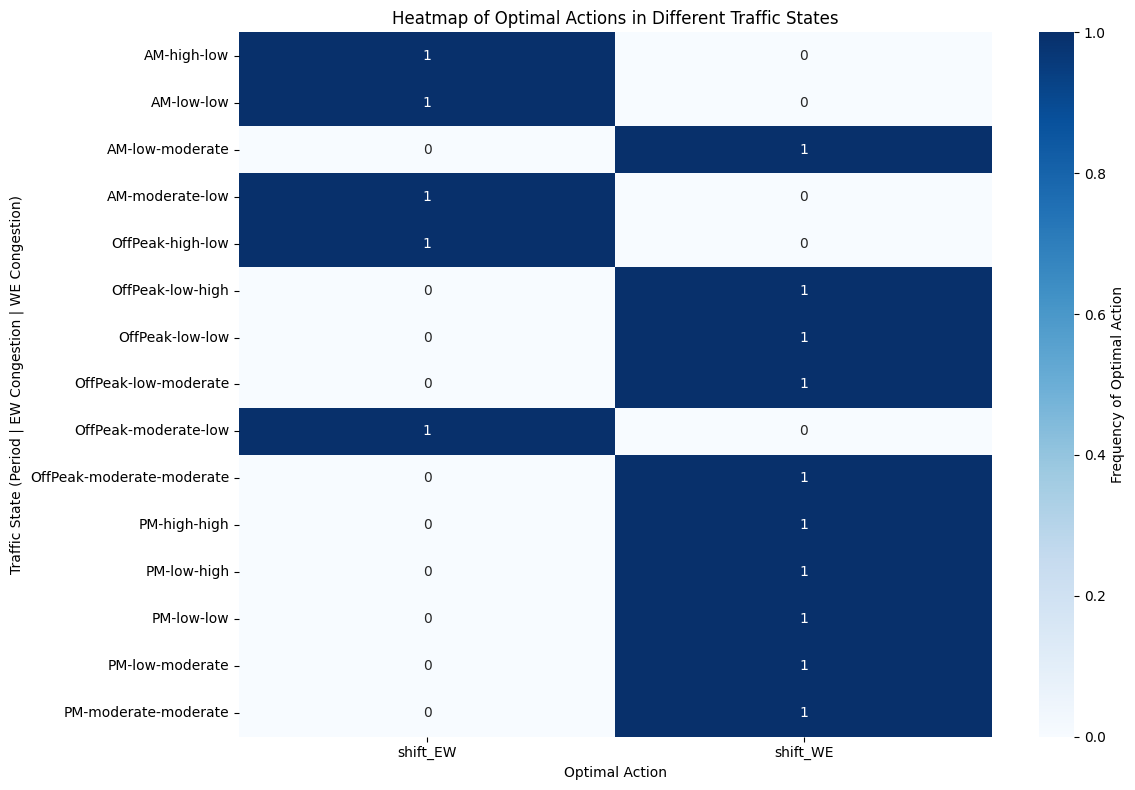

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an empty list to hold rows
policy_rows = []

# Convert states into readable format for visualization
for state in optimal_policy:
    period, ew_cong, we_cong = state
    optimal_action = optimal_policy[state]
    policy_rows.append({
        'Period': period,
        'EW Congestion': ew_cong,
        'WE Congestion': we_cong,
        'Optimal Action': optimal_action
    })

# Convert the list of rows into a DataFrame
policy_df = pd.DataFrame(policy_rows)

# Pivot table to create matrix format for heatmap (rows = states, columns = optimal actions)
pivot = policy_df.pivot_table(index=['Period', 'EW Congestion', 'WE Congestion'], columns='Optimal Action', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Frequency of Optimal Action'})
plt.title('Heatmap of Optimal Actions in Different Traffic States')
plt.ylabel('Traffic State (Period | EW Congestion | WE Congestion)')
plt.xlabel('Optimal Action')
plt.tight_layout()
plt.show()
